In [62]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from grokking import models, datasets

In [115]:
param_category_map = {
    "data": {"dataset", "train_frac", "shuffle_seed", "p"},
    "model": {"layers", "width", "heads", "dropout"},
    "optimizer": {"learning_rate", "weight_decay", "beta_1", "beta_2", "epsilon"},
    "training": {"train_batch_size", "epochs", "steps_per_epoch", "steps_per_execution"},
}

param_category_inv_map = {param: category for category, params in param_category_map.items() for param in params}
 
def validate_params(params):
    assert set(params.keys()) == set(param_category_inv_map.keys())
    
def params_subset(params, category):
    return {param: value for param, value in params.items() if param_category_inv_map[param] == category}

def build_model(params, data):
    n_classes = len({token for equation in data for token in equation})
    assert n_classes == params["p"]
    model = models.decoder_transformer_classifier(2, n_classes, n_classes, params["layers"], params["width"], params["heads"], params["dropout"])
    opt_params = params_subset(params, "optimizer")
    del opt_params["weight_decay"]  # for now as we're using Adam
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(**opt_params)
    )
    return model

def load_original_data(params):
    return datasets.load(params["dataset"], p=params["p"])

def load_epoch_checkpoint(model, dirname, epoch):
    checkpoint = Path(dirname) / f"checkpoints/weights-at-epoch-{epoch:04d}"
    model.load_weights(checkpoint)

def load_run(dirname):
    dirpath = Path(dirname)
    params = json.load((dirpath / "params.json").open("r"))
    validate_params(params)
    history = pd.read_json(dirpath / "history.json", lines=True).set_index("epoch")
    Xt, yt = json.load((dirpath / "data/train.json").open("r"))
    Xv, yv = json.load((dirpath / "data/val.json").open("r"))
    train = np.array(Xt), np.array(yt)
    val = np.array(Xv), np.array(yv)
    return params, history, train, val

params, history, train, val = load_run("runs/220822083455/")
original_data = load_original_data(params)
model = build_model(params, original_data)

In [123]:
tf.keras.backend.clear_session()
model_1 = build_model(params, original_data)
load_epoch_checkpoint(model_1, "runs/220822101635/", 490)
model_2 = build_model(params, original_data)
load_epoch_checkpoint(model_2, "runs/220822101635/", 440)

In [124]:
preds_1 = tf.math.argmax(model_1(val[0]), axis=-1)
preds_2 = tf.math.argmax(model_2(val[0]), axis=-1)
tf.reduce_mean(tf.cast(preds_1 == preds_2, tf.float32))

<tf.Tensor: shape=(), dtype=float32, numpy=0.27417642>

In [110]:
model_1(val[0])

<tf.Tensor: shape=(1882, 97), dtype=float32, numpy=
array([[-3208.0718, -3265.2527, -3311.1438, ..., -3341.4922, -3328.5527,
        -3218.2856],
       [-3434.2078, -3249.8284, -3320.1807, ..., -3398.9285, -3252.31  ,
        -3315.593 ],
       [-3083.8657, -3102.618 , -3093.5151, ..., -3095.2175, -3094.5408,
        -3096.0579],
       ...,
       [-3064.8796, -3120.2256, -2973.3442, ..., -3036.7253, -3088.5073,
        -2932.229 ],
       [-3135.349 , -3210.3552, -3093.6672, ..., -3101.9248, -3208.3037,
        -3115.429 ],
       [-2801.729 , -2864.1272, -2910.6104, ..., -2827.3708, -2810.9224,
        -2885.2783]], dtype=float32)>

In [90]:
with open("runs/220822092116/data/train.json", "r") as f:
    print([np.array(el) for el in json.load(f)])

[array([[14, 42],
       [20, 89],
       [90,  9],
       ...,
       [73, 94],
       [46,  8],
       [ 9, 18]]), array([31, 57, 69, ..., 22, 87, 74])]


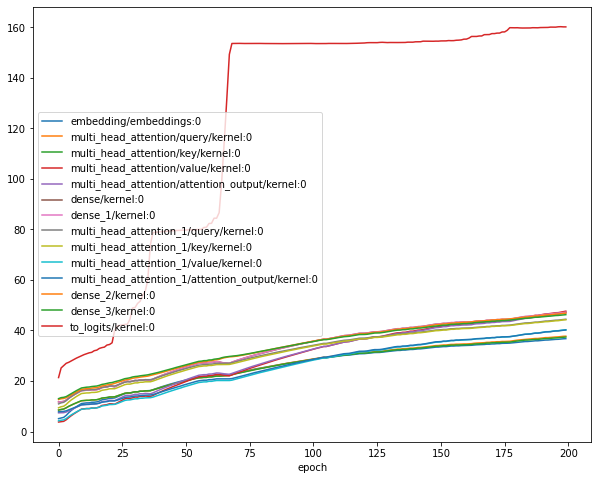

In [66]:
def plot_layer_weight_progression(history):
    layer_names = list(n for n in history.layer_weight_norms[0].keys() if "kernel" in n or "embeddings" in n)
    lwn_history = pd.DataFrame({n: history.layer_weight_norms.str[n] for n in layer_names})
    lwn_history.plot(figsize=(10, 8))
    
plot_layer_weight_progression(history)

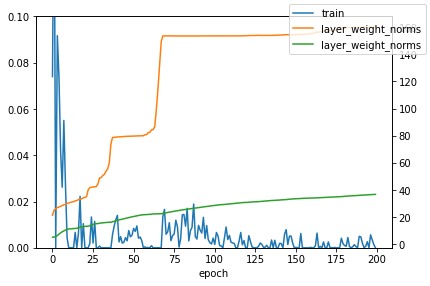

In [38]:
history.train.str["loss"].plot()
plt.ylim([0.0, 0.1])
plt.sca(plt.gca().twinx())
history.layer_weight_norms.str["to_logits/kernel:0"].plot(color="C1")
history.layer_weight_norms.str["embedding/embeddings:0"].plot(color="C2")
plt.gcf().legend()
plt.tight_layout()